In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

In [2]:
from sklearn.mixture import GaussianMixture

In [3]:
n_samples = 1000

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.035)

In [4]:
X_data, _ = noisy_moons
X_data = StandardScaler().fit_transform(X_data)

In [5]:
gm = GaussianMixture(n_components=3, n_init=3, verbose=2)

In [6]:
gm.fit(X_data)

Initialization 0
  Iteration 0	 time lapse 0.01982s	 ll change inf
  Iteration 10	 time lapse 0.01706s	 ll change 0.00225
  Iteration 20	 time lapse 0.02339s	 ll change 0.00291
  Iteration 30	 time lapse 0.01752s	 ll change 0.02509
  Iteration 40	 time lapse 0.02235s	 ll change 0.00155
  Iteration 50	 time lapse 0.01780s	 ll change 0.00178
Initialization converged: True	 time lapse 0.12175s	 ll -2.19002
Initialization 1
  Iteration 0	 time lapse 0.01305s	 ll change inf
  Iteration 10	 time lapse 0.01544s	 ll change 0.00301
  Iteration 20	 time lapse 0.01689s	 ll change 0.00287
  Iteration 30	 time lapse 0.01753s	 ll change 0.02394
  Iteration 40	 time lapse 0.01754s	 ll change 0.00162
Initialization converged: True	 time lapse 0.08636s	 ll -2.19175
Initialization 2
  Iteration 0	 time lapse 0.01193s	 ll change inf
  Iteration 10	 time lapse 0.01278s	 ll change 0.00225
  Iteration 20	 time lapse 0.01990s	 ll change 0.00291
  Iteration 30	 time lapse 0.01907s	 ll change 0.02509
  Iterati

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=3, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=2,
        verbose_interval=10, warm_start=False, weights_init=None)

In [7]:
from scipy.stats import multivariate_normal

In [8]:
gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], size=int(gm.weights_[0]*n_samples)))
for d in range(1,gm.n_components):
    gen=np.vstack((gen,multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=int(gm.weights_[d]*n_samples))))
np.random.shuffle(gen)
gen = np.array(gen)

In [9]:
num_anom = 1000
uniform = 4*np.random.rand(num_anom, 2)-2

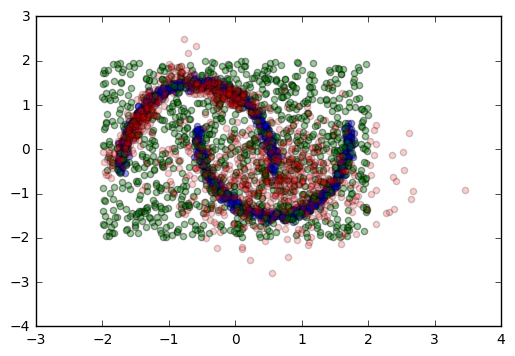

In [10]:
plt.scatter(X_data[:, 0], X_data[:, 1], alpha=0.4)
plt.scatter(uniform[:, 0], uniform[:, 1], c='g', alpha=0.4)
plt.scatter(gen[:, 0], gen[:, 1], c='r', alpha=0.2)
plt.show()

In [11]:
probabilities = np.empty((gm.n_components, gen.shape[0]))

In [12]:
for d in range(gm.n_components):
    probabilities[d] = multivariate_normal.pdf(gen, mean=gm.means_[d], 
                                                    cov=gm.covariances_[d], allow_singular=True)

In [13]:
gen.shape

(999, 2)

In [14]:
maxprob = np.max(probabilities, axis = 0)
gen_w = 1./maxprob

In [15]:
indices = gen_w.argsort()[-50:][::-1]

In [16]:
gen_w = np.delete(gen_w, indices)
gen = np.delete(gen, indices, axis = 0)

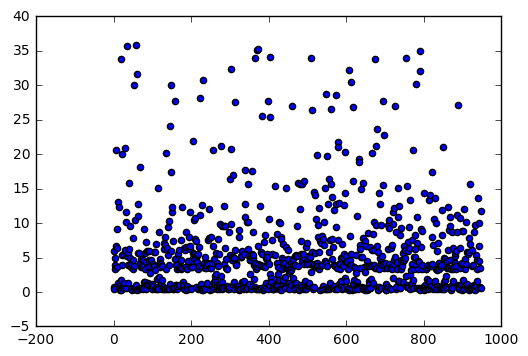

In [17]:
plt.scatter(np.arange(len(gen_w)), gen_w)
plt.show()

In [18]:
weights = np.ones((n_samples,1))

In [19]:
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)

In [20]:
gen_w_normed.sum(), np.sum(weights)

(999.99999999999989, 1000.0)

In [21]:
y1 = np.ones((X_data.shape[0],1))
y2 = np.zeros((gen.shape[0],1))

In [22]:
from sklearn.model_selection import train_test_split
indx_train_g, indx_test_g = train_test_split(np.arange(gen.shape[0]), test_size=0.2, random_state = 1)
indx_train, indx_test = train_test_split(np.arange(X_data.shape[0]), test_size=0.2, random_state = 1)

In [23]:
X_data[indx_train].shape

(800, 2)

In [24]:
gen[indx_train_g].shape

(759, 2)

In [25]:
X_train = np.vstack((X_data[indx_train], gen[indx_train_g]))
X_test = np.vstack((X_data[indx_test], gen[indx_test_g]))

y_train = np.vstack((y1[indx_train], y2[indx_train_g]))
y_test = np.vstack((y1[indx_test], y2[indx_test_g]))

weights_train = np.vstack((weights[indx_train].reshape(-1,1), gen_w_normed[indx_train_g].reshape(-1,1))).reshape(-1)
weights_test = np.vstack((weights[indx_test].reshape(-1,1), gen_w_normed[indx_test_g].reshape(-1,1))).reshape(-1)

In [26]:
import tensorflow as tf

s = tf.InteractiveSession()

import keras
from keras.models import Sequential
from keras import layers as L

Using TensorFlow backend.


In [27]:
net = Sequential()
net.add(L.Dense(6, input_shape=(2,), activation = 'relu'))
net.add(L.Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(lr=0.001)
net.compile(optimizer=adam, loss='binary_crossentropy')

In [28]:
history = net.fit(X_train, y_train, batch_size=32, epochs=10, validation_split = 0.1, verbose=1, shuffle=True)#, sample_weight=weights_train)

Train on 1403 samples, validate on 156 samples
Epoch 1/10
1403/1403 [==============================] - 0s - loss: 0.7129 - val_loss: 0.7340
Epoch 2/10
1403/1403 [==============================] - 0s - loss: 0.7036 - val_loss: 0.7644
Epoch 3/10
1403/1403 [==============================] - 0s - loss: 0.6971 - val_loss: 0.7888
Epoch 4/10
1403/1403 [==============================] - 0s - loss: 0.6927 - val_loss: 0.8034
Epoch 5/10
1403/1403 [==============================] - 0s - loss: 0.6893 - val_loss: 0.8207
Epoch 6/10
1403/1403 [==============================] - 0s - loss: 0.6870 - val_loss: 0.8316
Epoch 7/10
1403/1403 [==============================] - 0s - loss: 0.6853 - val_loss: 0.8389
Epoch 8/10
1403/1403 [==============================] - 0s - loss: 0.6841 - val_loss: 0.8445
Epoch 9/10
1403/1403 [==============================] - 0s - loss: 0.6833 - val_loss: 0.8435
Epoch 10/10
1403/1403 [==============================] - 0s - loss: 0.6825 - val_loss: 0.8509


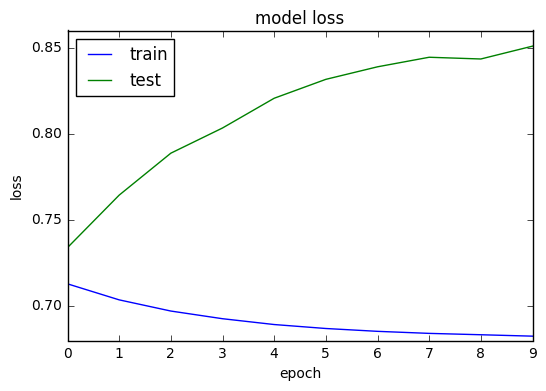

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
y_pred = net.predict(X_test, verbose=1)

 32/390 [=>............................] - ETA: 0s

In [31]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, confusion_matrix, average_precision_score


print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_score(y_test, y_pred)))
print ("roc_auc_score",roc_auc_score(y_test, y_pred))
print ("recall_score",recall_score(1-y_test, 1-np.round(y_pred)))
confusion_matrix(y_test, np.round(y_pred))

Average precision-recall score: 0.52
roc_auc_score 0.499447368421
recall_score 0.0


array([[  0, 190],
       [  0, 200]])

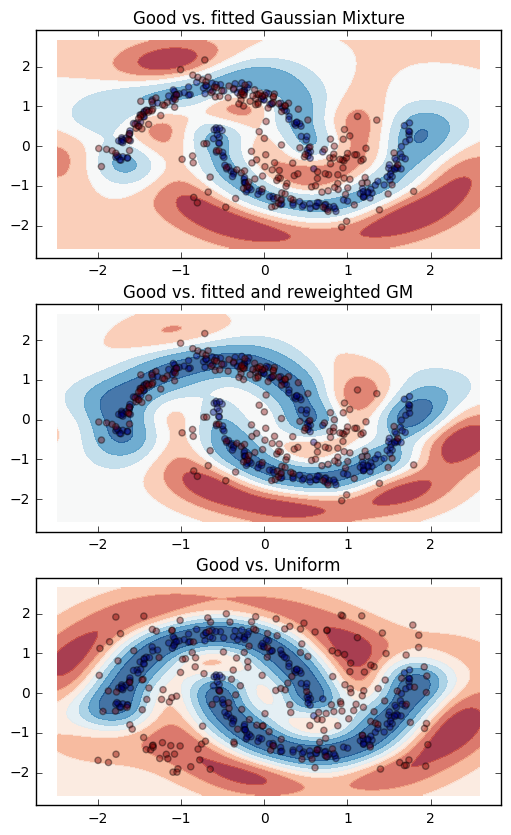

In [32]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

clf =  SVC(gamma=2, C=1)#AdaBoostClassifier(n_estimators=80)
    
cm = plt.cm.RdBu
x_min, x_max = np.vstack((X_train, X_test))[:, 0].min() - .5, np.vstack((X_train, X_test))[:, 0].max() + .5
y_min, y_max = np.vstack((X_train, X_test))[:, 1].min() - .5, np.vstack((X_train, X_test))[:, 1].max() + .5
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
fig = plt.figure(figsize=(6, 10))

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())



clf.fit(X_train, y_train.ravel())#, sample_weight=weights_train)
score = clf.score(X_test, y_test.ravel())

if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.subplot(3, 1, 1)
plt.title("Good vs. fitted Gaussian Mixture")
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(X_test[:, 0], X_test[:, 1], c=1-y_test, 
            edgecolors='k', alpha = 0.4)



clf.fit(X_train, y_train.ravel(), sample_weight=weights_train)
score = clf.score(X_test, y_test.ravel())

if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.subplot(3, 1, 2)
plt.title("Good vs. fitted and reweighted GM")
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(X_test[:, 0], X_test[:, 1], c=1-y_test,  
            edgecolors='k', alpha = 0.4)



clf.fit(np.vstack((X_data[indx_train], uniform[indx_train])),np.vstack((y1[indx_train], 1-y1[indx_train])).ravel())
score = clf.score(X_test, y_test.ravel())

if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.subplot(3, 1, 3)
plt.title("Good vs. Uniform")
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(np.vstack((X_data[indx_test], uniform[indx_test]))[:, 0],
            np.vstack((X_data[indx_test], uniform[indx_test]))[:, 1], 
            c=1-np.vstack((y1[indx_test], 1-y1[indx_test])), 
            edgecolors='k', alpha = 0.4)

plt.show()